In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
scores = np.load('../processed_data/D4_smallsample_short.npy')
smiles = pd.read_csv('../processed_data/D4_smallsample_short.smi')

# Fingerprint molecules

In [4]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from scipy import sparse

fingerprint_function = rdMolDescriptors.GetMorganFingerprintAsBitVect
pars = { "radius": 2,
                     "nBits": 32_768,
                     "invariants": [],
                     "fromAtoms": [],
                     "useChirality": False,
                     "useBondTypes": True,
                     "useFeatures": True,
            }




 #store bit indices in these:
row_idx = list()
col_idx = list()
        
#iterate through file, 
for count, smi in enumerate(smiles['smiles']):
    mol = Chem.MolFromSmiles(smi)
    fp = fingerprint_function(mol, **pars)
    onbits = list(fp.GetOnBits())
    #these bits all have the same row:
    row_idx += [count]*len(onbits)
    #and the column indices of those bits:
    col_idx+=onbits
            

        
#generate a sparse matrix out of the row,col indices:
unfolded_size = 32_768
fingerprint_matrix = sparse.coo_matrix((np.ones(len(row_idx)).astype(bool), (row_idx, col_idx)), 
                          shape=(max(row_idx)+1, unfolded_size))
#convert to csr matrix, it is better:
fingerprint_matrix =  sparse.csr_matrix(fingerprint_matrix)

# Examine docking score distribution

In [5]:
#find the 0.1 percentile score
cutoff =np.percentile(scores, 1.)

In [7]:
cutoff = -60

0.0003994966342408565


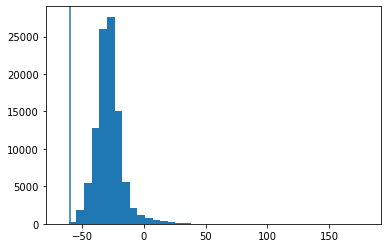

In [8]:
plt.hist(scores,bins=40)

#cutoff = -63.18515625

print((scores<cutoff).sum() / len(scores))
plt.axvline(cutoff)

# Run some monte carlo cross validation to double check the cutoff gives  reasonably similar results as AmpC

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score as apscore

y = (scores<cutoff).astype(int)

for i in range(10):
    idx = np.arange(len(y))
    np.random.shuffle(idx)
    
    train = idx[:np.int(len(y)*0.9)]
    test = idx[np.int(len(y)*0.9):]
    
    model = LogisticRegression(max_iter=10000,C=0.1)
    model.fit(fingerprint_matrix[train], y[train])
    
    #print performance improvement above a random classifier. 
    ap = apscore(y[test],model.predict_proba(fingerprint_matrix[test])[:,1])
    print(ap)


0.0045662100456621
0.0030318768876901867
0.004757914545493404
0.00511491651106553
0.004927984624219199
0.011124075141393835
0.0029166469452424036
0.0025549664139724437
0.006504484549489457
0.007128518439638785


# Pickle a trained model to pass over to the large sample analysis:

In [66]:

model = LogisticRegression(max_iter=10000,C=0.1)
model.fit(fingerprint_matrix, y)

LogisticRegression(C=0.1, max_iter=10000)

In [64]:
from joblib import dump
dump(model, '../processed_data/d4_smallModel.joblib') 

['../processed_data/d4_smallModel.joblib']